In [2]:
#install dependencies

In [3]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [4]:
#build data loading function

In [5]:
#define paths to files

In [6]:
CAPUCHIN_FILE=os.path.join('data','Parsed_Capuchinbird_Clips','XC3776-3.wav')
NOT_CAPUCHIN_FILE=os.path.join('data','Parsed_Not_Capuchinbird_Clips','afternoon-birds-song-in-forest-3.wav')

In [7]:
CAPUCHIN_FILE

'data\\Parsed_Capuchinbird_Clips\\XC3776-3.wav'

In [8]:
NOT_CAPUCHIN_FILE

'data\\Parsed_Not_Capuchinbird_Clips\\afternoon-birds-song-in-forest-3.wav'

In [9]:
#data loading function

In [10]:
def load_wav_16k_mono(filename):
    #load the encoded wav file
    file_contents=tf.io.read_file(filename)
    #decode wav (tensors by channels)
    wav, sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)
    #removes trailing axis
    wav=tf.squeeze(wav,axis=1)
    sample_rate=tf.cast(sample_rate,dtype=tf.int64)
    #goes from 44100Hz to 16000Hz- amplitude of the audio signal
    wav=tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
    return wav

In [11]:
#plot wave

In [12]:
wave=load_wav_16k_mono(CAPUCHIN_FILE)
nwave=load_wav_16k_mono(NOT_CAPUCHIN_FILE)

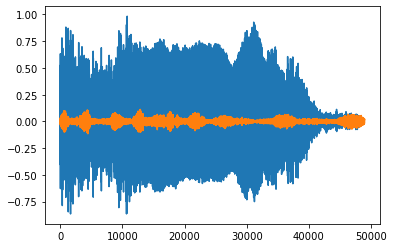

In [13]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [14]:
#create tensorflow dataset

In [15]:
#define paths to positive and negative data

In [16]:
POS=os.path.join('data','Parsed_Capuchinbird_clips')
NEG=os.path.join('data','Parsed_Not_Capuchinbird_clips')

In [17]:
#gives the files inside repsective folders in a string format
pos=tf.data.Dataset.list_files(POS+'\*.wav')
neg=tf.data.Dataset.list_files(NEG+'\*.wav')

In [18]:
#add labels and combine positive and negative samples

In [19]:
#just assigning 1 and zero so that it becomes binary classification problem

positives=tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives=tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
#added all data to a single variable
data=positives.concatenate(negatives)

In [20]:
negatives.as_numpy_iterator().next()

(b'data\\Parsed_Not_Capuchinbird_clips\\crickets-sound-effect-14.wav', 0.0)

In [21]:
data.shuffle(1000).as_numpy_iterator().next()

(b'data\\Parsed_Not_Capuchinbird_clips\\cricket-sounds-for-sleep-48.wav', 0.0)

In [22]:
#determine the avg length of a capuchin bird call

In [23]:
#calculate wave cycle length

In [24]:
lengths=[]
for file in os.listdir(os.path.join('data','Parsed_Capuchinbird_Clips')):
    tensor_wave=load_wav_16k_mono(os.path.join('data','Parsed_Capuchinbird_Clips',file))
    lengths.append(len(tensor_wave))

In [25]:
os.listdir(os.path.join('data','Parsed_Capuchinbird_Clips'))

['XC114131-0.wav',
 'XC114131-1.wav',
 'XC114131-2.wav',
 'XC114131-3.wav',
 'XC114131-4.wav',
 'XC114132-0.wav',
 'XC114132-1.wav',
 'XC114132-2.wav',
 'XC114132-3.wav',
 'XC114132-4.wav',
 'XC114132-5.wav',
 'XC114132-6.wav',
 'XC119294-0.wav',
 'XC16803-0.wav',
 'XC16803-1.wav',
 'XC16803-2.wav',
 'XC16804-0.wav',
 'XC16804-1.wav',
 'XC168899-0.wav',
 'XC178167-0.wav',
 'XC178167-1.wav',
 'XC178167-2.wav',
 'XC178167-3.wav',
 'XC178168-0.wav',
 'XC178168-1.wav',
 'XC178168-2.wav',
 'XC178168-3.wav',
 'XC178168-4.wav',
 'XC178168-5.wav',
 'XC178168-6.wav',
 'XC178168-7.wav',
 'XC201990-0.wav',
 'XC201990-1.wav',
 'XC201990-2.wav',
 'XC201990-3.wav',
 'XC201990-4.wav',
 'XC201990-5.wav',
 'XC216010-0.wav',
 'XC216010-1.wav',
 'XC216010-2.wav',
 'XC216010-3.wav',
 'XC216010-4.wav',
 'XC216010-5.wav',
 'XC216010-6.wav',
 'XC216010-7.wav',
 'XC216012-0.wav',
 'XC216012-1.wav',
 'XC216012-10.wav',
 'XC216012-11.wav',
 'XC216012-12.wav',
 'XC216012-13.wav',
 'XC216012-14.wav',
 'XC216012-1

In [26]:
#calculate mean, min, max

In [27]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [28]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [29]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [30]:
32000/16000

2.0

In [31]:
80000/16000

5.0

In [32]:
54516/16000

3.40725

In [33]:
#so the length of the audios range between 2mins to 5mins and 3mins on average 

In [34]:
#build preprocessing function to convert to spectrogram

In [35]:
#build preprocessing function

In [36]:
def preprocess(file_path,label):
    #load the file in its wave form
    wav=load_wav_16k_mono(file_path)
    #take approx. 3.4 secs of audio as it is the average
    wav=wav[:54516]
    #add zeros to files that are shorter than 3.4 secs
    zero_padding=tf.zeros([54516]-tf.shape(wav),dtype=tf.float32)
    wav=tf.concat([zero_padding,wav],0)
    #stft=short time fourier transform
    spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32)
    #everything becomes positive
    spectrogram=tf.abs(spectrogram)
    #have the spectrogram in the appropriate format for it to be used for deep learning
    #it is the number of channels part in convNet
    spectrogram=tf.expand_dims(spectrogram,axis=2)
    return spectrogram,label

In [37]:
#test out our function and viz the program

In [38]:
filepath,label=positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram,label=preprocess(filepath,label)

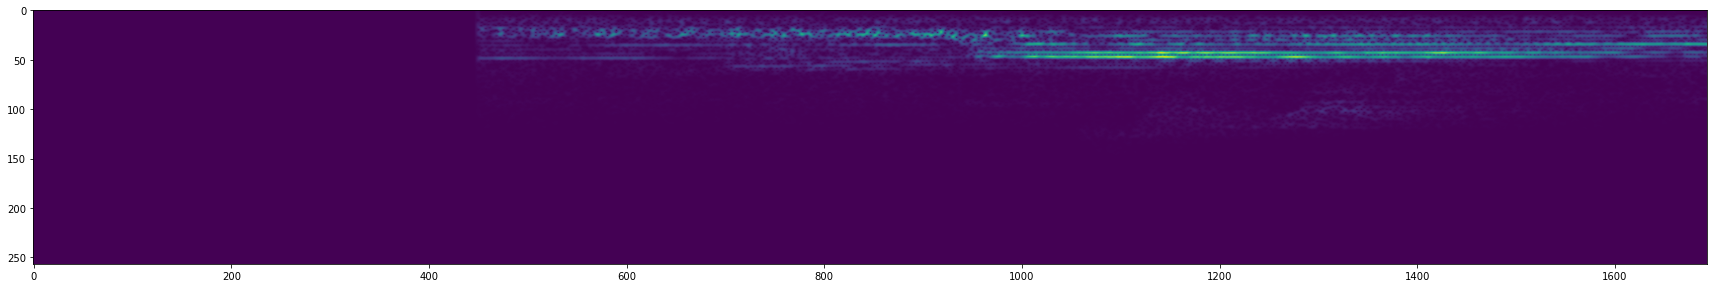

In [39]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [40]:
filepath,label=negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram,label=preprocess(filepath,label)

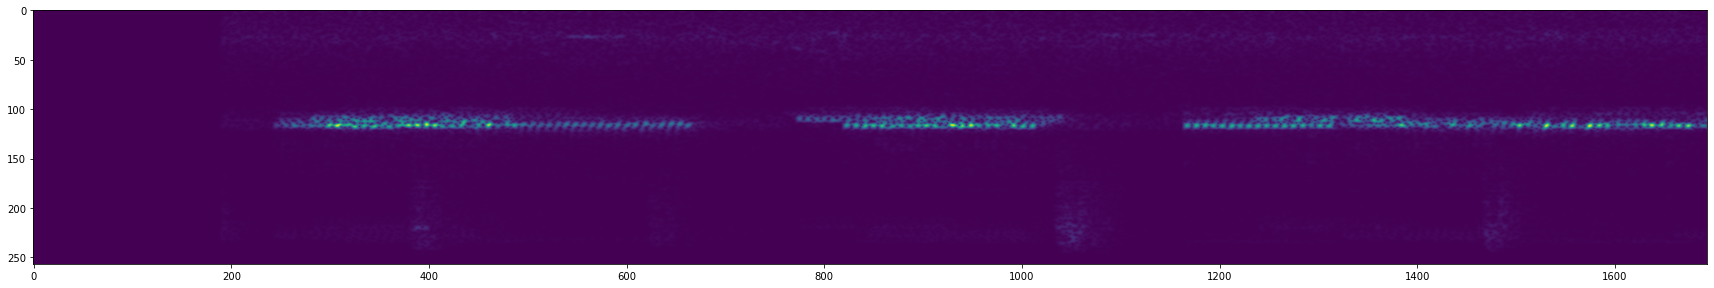

In [41]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [42]:
#create training and testing protions

In [43]:
#create tensorflow data pipeline

In [44]:
data=data.map(preprocess)
data=data.cache()
data=data.shuffle(buffer_size=1000)
data=data.batch(16)
data=data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [45]:
len(data)

51

In [46]:
train=data.take(36)
test=data.skip(36).take(15)

In [47]:
#test one batch

In [48]:
samples,labels=train.as_numpy_iterator().next()

In [49]:
samples.shape

(16, 1694, 257, 1)

In [50]:
#build deep learning model

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D

In [52]:
#build sequential model, compile and view summary

In [53]:
model=Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(1694,257,1)))
model.add(MaxPooling2D())
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [54]:
model.compile('Adam',loss=tf.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1692, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 846, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 844, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 422, 62, 16)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 418624)            0         
                                                                 
 dense (Dense)               (None, 128)               5

In [56]:
#fit model, view loss and KPI plots

In [57]:
hist=model.fit(train,epochs=4,validation_data=test)

Epoch 1/4
36/36 [==============================] - 131s 4s/step - loss: 0.9977 - recall: 0.8387 - precision: 0.8497 - val_loss: 0.1549 - val_recall: 0.9474 - val_precision: 0.9643
Epoch 2/4
36/36 [==============================] - 126s 3s/step - loss: 0.1478 - recall: 0.9740 - precision: 0.9804 - val_loss: 0.0269 - val_recall: 0.9508 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 125s 3s/step - loss: 0.0292 - recall: 0.9744 - precision: 0.9870 - val_loss: 0.0073 - val_recall: 0.9857 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 119s 3s/step - loss: 0.0060 - recall: 0.9882 - precision: 1.0000 - val_loss: 7.4813e-04 - val_recall: 1.0000 - val_precision: 1.0000


In [58]:
hist.history

{'loss': [0.9976750612258911,
  0.14779776334762573,
  0.029156513512134552,
  0.006048884708434343],
 'recall': [0.8387096524238586,
  0.9740259647369385,
  0.9743589758872986,
  0.9882352948188782],
 'precision': [0.8496732115745544,
  0.9803921580314636,
  0.9870129823684692,
  1.0],
 'val_loss': [0.15491920709609985,
  0.02688044123351574,
  0.007280275691300631,
  0.0007481270004063845],
 'val_recall': [0.9473684430122375,
  0.9508196711540222,
  0.9857142567634583,
  1.0],
 'val_precision': [0.9642857313156128, 1.0, 1.0, 1.0]}

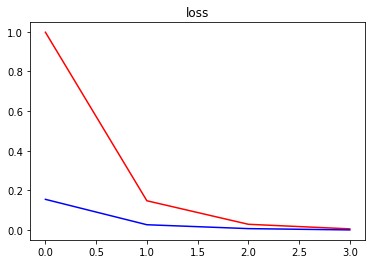

In [59]:
plt.title('loss')
plt.plot(hist.history['loss'],'r')
plt.plot(hist.history['val_loss'],'b')

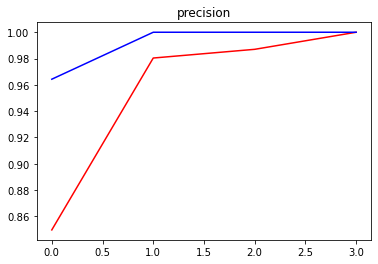

In [60]:
plt.title('precision')
plt.plot(hist.history['precision'],'r')
plt.plot(hist.history['val_precision'],'b')

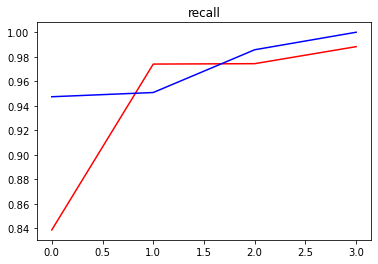

In [61]:
plt.title('recall')
plt.plot(hist.history['recall'],'r')
plt.plot(hist.history['val_recall'],'b')

In [62]:
#make a prediction on a sinlge clip

In [63]:
#get one batch and make a prediction

In [64]:
X_test,y_test=test.as_numpy_iterator().next()

In [65]:
print(X_test.shape)
print(y_test.shape)

(16, 1694, 257, 1)
(16,)


In [66]:
yhat=model.predict(X_test)

1/1 [==============================] - 1s 678ms/step


In [67]:
yhat

array([[1.5967342e-11],
       [9.9989742e-01],
       [1.0811636e-06],
       [3.2721107e-07],
       [8.8506691e-10],
       [4.6688569e-08],
       [1.0000000e+00],
       [9.9957037e-01],
       [9.4129471e-05],
       [5.9108311e-06],
       [1.8721567e-10],
       [4.5057527e-06],
       [1.1373499e-10],
       [1.0000000e+00],
       [2.5958871e-18],
       [4.0742738e-17]], dtype=float32)

In [68]:
#converting logits to classes

In [69]:
yhat=[1 if prediction>0.5 else 0 for prediction in yhat ]

In [70]:
yhat

[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0]

In [71]:
y_test.astype(int)

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [72]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [73]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [115]:
#100% correct prediction

In [116]:
#build forest parsing functions

In [117]:
#load up MP3s

In [118]:
def load_mp3_16k_mono(filename):
    #load the encoded mp3 file
    res=tfio.audio.AudioIOTensor(filename)
#convert to tensor and combine channels
    tensor=res.to_tensor()
    tensor=tf.math.reduce_sum(tensor,axis=1)/2
    #extract sample rate and cast
    sample_rate=res.rate
    sample_rate=tf.cast(sample_rate,dtype=tf.int64)
    #resample to 16kHz
    wav=tfio.audio.resample(tensor,rate_in=sample_rate,rate_out=16000)
    return wav

In [119]:
mp3=os.path.join('data','Forest Recordings','recording_00.mp3')

In [120]:
wav=load_mp3_16k_mono(mp3)

In [121]:
#this will give different slices of the longer clips
audio_slices=tf.keras.utils.timeseries_dataset_from_array(wav,wav,sequence_length=54156,sequence_stride=54156,batch_size=1)

In [122]:
samples,index=audio_slices.as_numpy_iterator().next()

In [123]:
samples.shape

(1, 54156)

In [124]:
len(audio_slices)

53

In [125]:
#so we have 53 clips of size 54156 each

In [126]:
#build function to convert clips to spectrograms

In [130]:
def preprocess_mp3(sample,index):
    #load the file in its wave form
    sample=sample[0]
    #add zeros to files that are shorter than 3.4 secs
    zero_padding=tf.zeros([54516]-tf.shape(sample),dtype=tf.float32)
    wav=tf.concat([zero_padding,sample],0)
    #stft=short time fourier transform
    spectrogram=tf.signal.stft(wav,frame_length=320,frame_step=32)
    #everything becomes positive
    spectrogram=tf.abs(spectrogram)
    #have the spectrogram in the appropriate format for it to be used for deep learning
    #it is the number of channels part in convNet
    spectrogram=tf.expand_dims(spectrogram,axis=2)
    return spectrogram

In [131]:
#convert longer clips int windows and make predictions

In [135]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=54156, sequence_stride=54156, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [150]:
yhat=model.predict(audio_slices)
yhat=[1 if prediction>0.99 else 0 for prediction in yhat]

1/1 [==============================] - 2s 2s/step


In [151]:
yhat

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [152]:
len(yhat)

53

In [153]:
#we've got consecutive predictions in the files too

In [154]:
#group consecutive detections

In [155]:
from itertools import groupby

In [156]:
yhat=[key for key,group in groupby(yhat)]
calls=tf.math.reduce_sum(yhat).numpy()

In [157]:
yhat

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [159]:
calls=tf.math.reduce_sum(yhat)

In [161]:
print(calls)

tf.Tensor(5, shape=(), dtype=int32)


In [162]:
#make predictions

In [163]:
#loop over all recordings and make predictions

In [164]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=54156, sequence_stride=54156, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 2s 2s/step


In [166]:
print(results)

{'recording_00.mp3': array([[3.09163351e-02],
       [4.82830964e-02],
       [4.60467078e-02],
       [9.95853543e-01],
       [9.52322006e-01],
       [1.13138240e-02],
       [1.01638347e-01],
       [2.40350235e-02],
       [6.20647632e-02],
       [2.71913894e-02],
       [3.21695022e-02],
       [1.06821164e-01],
       [1.00000000e+00],
       [5.13358295e-01],
       [8.07309243e-06],
       [2.82831769e-02],
       [8.43672976e-02],
       [3.50434184e-01],
       [5.75304702e-02],
       [1.30676389e-01],
       [5.29614151e-01],
       [9.99999702e-01],
       [8.14166963e-01],
       [4.43668514e-02],
       [1.34112373e-01],
       [8.56564566e-02],
       [8.78054649e-02],
       [2.26749927e-01],
       [6.93404302e-02],
       [9.08847228e-02],
       [1.08118586e-01],
       [3.85870636e-01],
       [1.00000000e+00],
       [2.07027391e-01],
       [8.43189657e-02],
       [1.37336180e-01],
       [1.69791192e-01],
       [2.59275556e-01],
       [8.88142511e-02],
    

In [167]:
#converting predictions to classes

In [169]:
class_preds={}
for file,logits in results.items():
    class_preds[file]=[1 if prediction>0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [170]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 5,
 'recording_05.mp3': 0,
 'recording_06.mp3': 6,
 'recording_07.mp3': 2,
 'recording_08.mp3': 18,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 0,
 'recording_16.mp3': 5,
 'recording_17.mp3': 8,
 'recording_18.mp3': 0,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 2,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 2,
 'recording_29.mp3': 0,
 'recording_30.mp3': 1,
 'recording_31.mp3': 1,
 'recording_32.mp3': 1,
 'recording_33.mp3': 0,
 'recording_34.mp3': 3,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 2,
 'recording_38.mp3': 8,
 'recording_39.mp3': 2,
 'recording_40.mp3': 1,
 'recording_41.

In [171]:
#export results

In [172]:
import csv

In [173]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])